In [8]:
import pandas as pd
import os
import numpy as np
import time
import tensorflow.keras.initializers
import statistics
import tensorflow.keras as keras
from sklearn import metrics
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Flatten, Reshape, LeakyReLU, Dense, Activation, Dropout, InputLayer, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import scipy.interpolate
import logging, os
from IPython import display
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn')

In [9]:
from fruit_spectra import randFission, randGauss, randHighEnergy, randEvap

In [10]:
def fission(N):
    y = []
    for i in range(N):
        y.append(randFission())
    y = np.array(y)
    x = np.matmul(y, cm.T)
    return x,y
    
def gauss(N):
    y = []
    for i in range(N):
        y.append(randGauss())
    y = np.array(y)
    x = np.matmul(y, cm.T)
    return x,y

def highenergy(N):
    y = []
    for i in range(N):
        y.append(randHighEnergy())
    y = np.array(y)
    x = np.matmul(y, cm.T)
    return x,y

def evap(N):
    y = []
    for i in range(N):
        y.append(randEvap())
    y = np.array(y)
    x = np.matmul(y, cm.T)
    return x,y

In [11]:
import data_generation

In [12]:
# ~~~ ADDED ~~ ##

# Data directly taken from PDF
Ebins = np.array([1.00E-03,2.15E-03,4.64E-03,1.00E-02,2.15E-02,4.64E-02,1.00E-01,2.15E-01,4.64E-01,1.00E+00,2.15E+00,4.64E+00,1.00E+01,2.15E+01,4.64E+01,1.00E+02,2.15E+02,4.64E+02,1.00E+03,2.15E+03,4.64E+03,1.00E+04,1.25E+04,1.58E+04,1.99E+04,2.51E+04,3.16E+04,3.98E+04,5.01E+04,6.30E+04,7.94E+04,1.00E+05,1.25E+05,1.58E+05,1.99E+05,2.51E+05,3.16E+05,3.98E+05,5.01E+05,6.30E+05,7.94E+05,1.00E+06,1.25E+06,1.58E+06,1.99E+06,2.51E+06,3.16E+06,3.98E+06,5.01E+06,6.30E+06,7.94E+06,1.00E+07,1.58E+07])

EbinsExtended = np.array([1.00E-03,2.15E-03,4.64E-03,1.00E-02,2.15E-02,4.64E-02,1.00E-01,2.15E-01,4.64E-01,1.00E+00,2.15E+00,4.64E+00,1.00E+01,2.15E+01,4.64E+01,1.00E+02,2.15E+02,4.64E+02,1.00E+03,2.15E+03,4.64E+03,1.00E+04,1.25E+04,1.58E+04,1.99E+04,2.51E+04,3.16E+04,3.98E+04,5.01E+04,6.30E+04,7.94E+04,1.00E+05,1.25E+05,1.58E+05,1.99E+05,2.51E+05,3.16E+05,3.98E+05,5.01E+05,6.30E+05,7.94E+05,1.00E+06,1.25E+06,1.58E+06,1.99E+06,2.51E+06,3.16E+06,3.98E+06,5.01E+06,6.30E+06,7.94E+06,1.00E+07,1.58E+07, 2.51E+07])
lethargies = []
for i in range(len(Ebins)):
    lethargies.append(np.log(EbinsExtended[i + 1]) - np.log(EbinsExtended[i]))
    
cm = np.array([
[6.11E+00,5.60E+00,4.80E+00,3.89E+00,3.03E+00,2.27E+00,1.64E+00,1.17E+00,8.20E-01,5.72E-01,3.94E-01,2.73E-01,1.90E-01,1.28E-01,8.88E-02,6.02E-02,4.05E-02,2.79E-02,1.91E-02,1.27E-02,9.01E-03,6.86E-03,6.24E-03,5.62E-03,4.99E-03,4.37E-03,3.83E-03,3.36E-03,2.90E-03,2.43E-03,1.97E-03,1.64E-03,1.47E-03,1.31E-03,1.15E-03,9.96E-04,8.95E-04,8.61E-04,8.28E-04,7.94E-04,7.60E-04,7.22E-04,6.79E-04,6.37E-04,5.94E-04,5.51E-04,4.94E-04,4.19E-04,3.44E-04,2.70E-04,1.97E-04,1.39E-04,1.00E-04],
[7.36E-01,8.08E-01,9.34E-01,1.12E+00,1.36E+00,1.72E+00,2.11E+00,2.38E+00,2.47E+00,2.46E+00,2.37E+00,2.24E+00,2.04E+00,1.85E+00,1.65E+00,1.47E+00,1.30E+00,1.14E+00,1.01E+00,8.83E-01,7.64E-01,6.98E-01,6.69E-01,6.39E-01,6.09E-01,5.81E-01,5.54E-01,5.26E-01,4.99E-01,4.71E-01,4.41E-01,4.09E-01,3.77E-01,3.45E-01,3.13E-01,2.81E-01,2.49E-01,2.17E-01,1.87E-01,1.59E-01,1.34E-01,1.11E-01,9.38E-02,7.58E-02,5.80E-02,4.42E-02,3.52E-02,2.63E-02,1.95E-02,1.52E-02,1.10E-02,7.43E-03,4.65E-03],
[5.98E-01,6.57E-01,7.58E-01,9.00E-01,1.08E+00,1.42E+00,1.89E+00,2.27E+00,2.51E+00,2.65E+00,2.69E+00,2.67E+00,2.58E+00,2.45E+00,2.29E+00,2.14E+00,1.98E+00,1.83E+00,1.67E+00,1.53E+00,1.39E+00,1.31E+00,1.27E+00,1.23E+00,1.20E+00,1.16E+00,1.13E+00,1.09E+00,1.05E+00,1.02E+00,9.77E-01,9.33E-01,8.87E-01,8.35E-01,7.78E-01,7.19E-01,6.57E-01,5.94E-01,5.27E-01,4.61E-01,3.96E-01,3.39E-01,2.90E-01,2.42E-01,1.94E-01,1.54E-01,1.24E-01,9.54E-02,7.21E-02,5.66E-02,4.15E-02,2.81E-02,1.77E-02],
[5.01E-01,5.50E-01,6.34E-01,7.50E-01,9.18E-01,1.22E+00,1.62E+00,2.00E+00,2.31E+00,2.52E+00,2.66E+00,2.75E+00,2.75E+00,2.71E+00,2.63E+00,2.53E+00,2.41E+00,2.30E+00,2.18E+00,2.04E+00,1.92E+00,1.84E+00,1.81E+00,1.78E+00,1.74E+00,1.71E+00,1.67E+00,1.64E+00,1.61E+00,1.57E+00,1.53E+00,1.49E+00,1.44E+00,1.38E+00,1.32E+00,1.25E+00,1.17E+00,1.09E+00,9.97E-01,8.96E-01,7.96E-01,6.97E-01,6.02E-01,5.13E-01,4.24E-01,3.47E-01,2.85E-01,2.24E-01,1.77E-01,1.49E-01,1.21E-01,7.95E-02,4.26E-02],
[4.15E-01,4.55E-01,5.24E-01,6.18E-01,7.61E-01,1.01E+00,1.36E+00,1.72E+00,2.04E+00,2.27E+00,2.45E+00,2.58E+00,2.64E+00,2.67E+00,2.66E+00,2.63E+00,2.58E+00,2.51E+00,2.43E+00,2.35E+00,2.26E+00,2.21E+00,2.18E+00,2.15E+00,2.13E+00,2.10E+00,2.08E+00,2.06E+00,2.04E+00,2.02E+00,1.99E+00,1.95E+00,1.92E+00,1.88E+00,1.83E+00,1.77E+00,1.70E+00,1.61E+00,1.51E+00,1.38E+00,1.26E+00,1.13E+00,1.00E+00,8.67E-01,7.33E-01,6.13E-01,5.10E-01,4.08E-01,3.30E-01,2.80E-01,2.30E-01,1.55E-01,8.39E-02],
[3.43E-01,3.75E-01,4.31E-01,5.11E-01,6.31E-01,8.34E-01,1.12E+00,1.43E+00,1.72E+00,1.95E+00,2.13E+00,2.29E+00,2.39E+00,2.46E+00,2.50E+00,2.51E+00,2.52E+00,2.52E+00,2.47E+00,2.44E+00,2.39E+00,2.36E+00,2.35E+00,2.34E+00,2.33E+00,2.32E+00,2.31E+00,2.31E+00,2.30E+00,2.29E+00,2.28E+00,2.27E+00,2.26E+00,2.24E+00,2.22E+00,2.19E+00,2.13E+00,2.07E+00,1.97E+00,1.86E+00,1.73E+00,1.59E+00,1.42E+00,1.25E+00,1.08E+00,9.20E-01,7.60E-01,6.27E-01,5.14E-01,4.09E-01,3.03E-01,2.25E-01,1.40E-01],
[2.80E-01,3.07E-01,3.53E-01,4.23E-01,5.13E-01,6.91E-01,9.32E-01,1.18E+00,1.41E+00,1.62E+00,1.81E+00,1.95E+00,2.07E+00,2.18E+00,2.24E+00,2.29E+00,2.32E+00,2.34E+00,2.36E+00,2.36E+00,2.33E+00,2.33E+00,2.33E+00,2.33E+00,2.34E+00,2.34E+00,2.35E+00,2.37E+00,2.38E+00,2.39E+00,2.41E+00,2.43E+00,2.44E+00,2.46E+00,2.47E+00,2.47E+00,2.44E+00,2.40E+00,2.33E+00,2.23E+00,2.10E+00,1.98E+00,1.82E+00,1.63E+00,1.45E+00,1.26E+00,1.07E+00,8.88E-01,7.36E-01,6.29E-01,5.22E-01,3.61E-01,2.04E-01],
[1.85E-01,2.05E-01,2.34E-01,2.79E-01,3.42E-01,4.57E-01,6.16E-01,7.74E-01,9.38E-01,1.08E+00,1.22E+00,1.34E+00,1.44E+00,1.52E+00,1.61E+00,1.69E+00,1.74E+00,1.80E+00,1.87E+00,1.90E+00,1.92E+00,1.96E+00,1.98E+00,2.00E+00,2.02E+00,2.05E+00,2.08E+00,2.12E+00,2.16E+00,2.20E+00,2.25E+00,2.31E+00,2.37E+00,2.43E+00,2.50E+00,2.57E+00,2.62E+00,2.66E+00,2.68E+00,2.67E+00,2.61E+00,2.53E+00,2.42E+00,2.25E+00,2.06E+00,1.82E+00,1.57E+00,1.36E+00,1.16E+00,9.63E-01,7.98E-01,5.95E-01,3.53E-01],
[1.18E-01,1.30E-01,1.52E-01,1.79E-01,2.13E-01,2.91E-01,3.95E-01,5.07E-01,6.09E-01,7.04E-01,7.92E-01,8.66E-01,9.43E-01,1.02E+00,1.08E+00,1.14E+00,1.20E+00,1.25E+00,1.31E+00,1.37E+00,1.42E+00,1.46E+00,1.48E+00,1.50E+00,1.53E+00,1.55E+00,1.58E+00,1.62E+00,1.67E+00,1.73E+00,1.80E+00,1.87E+00,1.95E+00,2.05E+00,2.15E+00,2.27E+00,2.41E+00,2.52E+00,2.59E+00,2.65E+00,2.70E+00,2.71E+00,2.67E+00,2.58E+00,2.44E+00,2.25E+00,2.02E+00,1.78E+00,1.55E+00,1.31E+00,1.07E+00,8.07E-01,5.25E-01],
[7.19E-02,8.04E-02,9.38E-02,1.13E-01,1.40E-01,1.84E-01,2.52E-01,3.21E-01,3.84E-01,4.42E-01,5.04E-01,5.58E-01,6.06E-01,6.49E-01,6.77E-01,7.23E-01,7.85E-01,8.28E-01,8.73E-01,9.13E-01,9.47E-01,9.90E-01,1.01E+00,1.04E+00,1.06E+00,1.08E+00,1.12E+00,1.16E+00,1.21E+00,1.25E+00,1.32E+00,1.38E+00,1.46E+00,1.56E+00,1.68E+00,1.80E+00,1.95E+00,2.08E+00,2.22E+00,2.35E+00,2.47E+00,2.57E+00,2.65E+00,2.64E+00,2.54E+00,2.38E+00,2.16E+00,2.01E+00,1.87E+00,1.62E+00,1.31E+00,1.02E+00,6.80E-01],
[3.63E-02,4.04E-02,4.84E-02,5.66E-02,6.52E-02,8.84E-02,1.21E-01,1.55E-01,1.90E-01,2.19E-01,2.43E-01,2.75E-01,2.99E-01,3.16E-01,3.39E-01,3.64E-01,3.90E-01,4.13E-01,4.36E-01,4.68E-01,5.00E-01,5.23E-01,5.34E-01,5.45E-01,5.56E-01,5.70E-01,5.91E-01,6.15E-01,6.37E-01,6.64E-01,7.03E-01,7.52E-01,8.14E-01,8.93E-01,9.84E-01,1.08E+00,1.21E+00,1.35E+00,1.52E+00,1.69E+00,1.88E+00,2.06E+00,2.22E+00,2.35E+00,2.41E+00,2.36E+00,2.22E+00,2.13E+00,2.03E+00,1.80E+00,1.56E+00,1.24E+00,8.69E-01],
[2.72E-02,3.05E-02,3.71E-02,4.49E-02,5.41E-02,6.96E-02,9.36E-02,1.26E-01,1.48E-01,1.70E-01,1.92E-01,2.18E-01,2.33E-01,2.37E-01,2.65E-01,2.89E-01,3.08E-01,3.26E-01,3.46E-01,3.70E-01,3.83E-01,4.06E-01,4.22E-01,4.38E-01,4.53E-01,4.69E-01,4.83E-01,4.97E-01,5.10E-01,5.29E-01,5.61E-01,6.09E-01,6.70E-01,7.43E-01,8.24E-01,9.19E-01,1.03E+00,1.14E+00,1.29E+00,1.46E+00,1.66E+00,1.85E+00,2.02E+00,2.19E+00,2.30E+00,2.29E+00,2.18E+00,2.10E+00,2.03E+00,1.82E+00,1.60E+00,1.31E+00,9.15E-01],
[1.05E-02,1.11E-02,1.29E-02,1.55E-02,1.94E-02,2.79E-02,3.72E-02,4.61E-02,5.23E-02,5.95E-02,7.00E-02,7.80E-02,8.42E-02,8.85E-02,9.14E-02,1.01E-01,1.17E-01,1.20E-01,1.28E-01,1.34E-01,1.43E-01,1.46E-01,1.54E-01,1.62E-01,1.66E-01,1.65E-01,1.67E-01,1.73E-01,1.87E-01,2.06E-01,2.26E-01,2.40E-01,2.54E-01,2.84E-01,3.25E-01,3.79E-01,4.50E-01,5.37E-01,6.52E-01,7.77E-01,9.34E-01,1.12E+00,1.32E+00,1.51E+00,1.68E+00,1.77E+00,1.77E+00,1.88E+00,1.98E+00,1.89E+00,1.68E+00,1.43E+00,1.05E+00],
[1.65E-03,2.14E-03,2.62E-03,3.40E-03,4.49E-03,5.06E-03,6.08E-03,8.28E-03,1.04E-02,1.26E-02,1.46E-02,1.60E-02,1.70E-02,1.80E-02,2.01E-02,2.21E-02,2.39E-02,2.40E-02,2.27E-02,2.46E-02,2.65E-02,2.94E-02,3.12E-02,3.30E-02,3.48E-02,3.63E-02,3.72E-02,3.78E-02,3.84E-02,4.01E-02,4.48E-02,5.09E-02,5.71E-02,6.37E-02,7.14E-02,8.52E-02,1.06E-01,1.32E-01,1.73E-01,2.28E-01,3.12E-01,4.31E-01,5.70E-01,7.23E-01,8.93E-01,1.03E+00,1.11E+00,1.31E+00,1.55E+00,1.59E+00,1.52E+00,1.40E+00,1.09E+00],
[4.83E-04,4.94E-04,5.05E-04,6.48E-04,9.25E-04,1.11E-03,1.21E-03,1.33E-03,1.45E-03,1.63E-03,1.87E-03,2.12E-03,3.00E-03,4.46E-03,4.11E-03,3.78E-03,3.54E-03,3.66E-03,4.27E-03,4.84E-03,5.42E-03,6.01E-03,6.35E-03,6.69E-03,7.03E-03,7.31E-03,7.49E-03,7.62E-03,7.76E-03,7.97E-03,8.39E-03,9.16E-03,1.03E-02,1.20E-02,1.42E-02,1.83E-02,2.47E-02,3.10E-02,4.07E-02,5.80E-02,8.93E-02,1.39E-01,2.08E-01,3.07E-01,4.30E-01,5.79E-01,7.51E-01,9.22E-01,1.10E+00,1.22E+00,1.25E+00,1.22E+00,1.08E+00]])

# Showing that CM has linearly independent rows

In [13]:
u, s, v = np.linalg.svd(cm)
s

array([3.43699227e+01, 1.50746339e+01, 1.08827539e+01, 6.08839211e+00,
       2.58942671e+00, 9.15283523e-01, 2.80455870e-01, 1.43515861e-01,
       8.99342843e-02, 7.44468059e-02, 5.54268989e-02, 4.06233120e-02,
       3.74714753e-02, 3.72760207e-02, 2.34541185e-02])

In [14]:
# Loads the real-world data from IAEA tecdoc
def loadXY():

    '''
    Can't figure out how to pass non-optimiziable variable to the bayes opt
    module. Just load them from pickle everytime in evaluate_network()
    '''
    unfolding_data = pd.read_pickle("/g/g15/mcgreivy/NeutronSpectraGeneration/IAEA_data/unfolding_data.pkl")

    X = np.zeros((251,15))
    Y = np.zeros((251,53))
    for row in range(251):
        #X[row,:] = unfolding_data['Detector Response'][row]
        Y[row,:] = unfolding_data['Spectrum'][row][0:53]
    
    # Divides out the lethargy interval
    for y in Y:
        for i in range(len(Ebins)):
            y[i] = y[i] * lethargies[i]
    
    # Fixes normalization back to 1 because of precision errors
    for i in range(len(Y)):
        Y[i] = Y[i] / np.sum(Y[i])
    
    # Multiplies by the conversion matrix to determine the detector response
    X = []
    for y in Y:
        X.append(np.matmul(cm, y))
    X = np.array(X)
    
    return X,Y

x,y = loadXY()

# Residual Computation

In [15]:
IAEA = lambda _0, _1 : loadXY()
PSA = data_generation.PSA
FRUIT = data_generation.FRUIT
GAUSS = data_generation.GAUSS
GAN = data_generation.GAN
RAND = data_generation.RAND

DATA_GENS = [IAEA, PSA, FRUIT, RAND]
labels = ["IAEA", "PSA", "FRUIT", "RAND"]

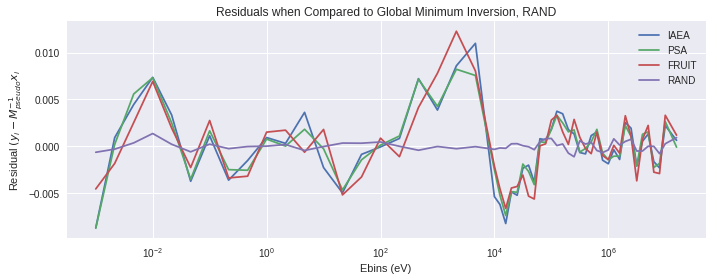

In [16]:
fig, axs = plt.subplots(1, 1, figsize = (10,4))

for i in range(len(DATA_GENS)):
    
    x,y = DATA_GENS[i](2000, loadXY()[1])
    
    resid = np.zeros(len(Ebins))
    for j in range(len(x)):
        resid += (y[j] - np.matmul(np.linalg.pinv(cm), x[j]))

    resid = resid / (j + 1)

    axs.plot(Ebins, resid, label = labels[i])
    axs.set_xscale("log")
    
    axs.set_xlabel("Ebins (eV)")
    axs.set_ylabel("Residual $(y_i - M_{pseudo}^{-1} x_i$")
    axs.set_title("Residuals when Compared to Global Minimum Inversion, " + labels[i])
    
plt.tight_layout()
plt.savefig("residuals_actual.png", dpi = 500)
plt.legend()

In [17]:
x,y = loadXY()

x,y = data_generation.PSA(5000, y)
wPSA = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

x,y = data_generation.FRUIT(5000, [])
wFRUIT = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

x,y = data_generation.RAND(5000, [])
wRAND = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

In [18]:
x,y = loadXY()

mseMPinv = 0
msePSA = 0
mseFRUIT = 0
mseRAND = 0

MPinv = np.linalg.pinv(cm)

for i in range(x.shape[0]):
    mseMPinv += np.mean((y[i] - np.matmul(MPinv, x[i]))**2)
    msePSA += np.mean((y[i] - np.matmul(x[i], wPSA))**2)
    mseFRUIT += np.mean((y[i] - np.matmul(x[i], wFRUIT))**2)
    mseRAND += np.mean((y[i] - np.matmul(x[i], wRAND))**2)

mseMPinv /= i + 1
msePSA /= i + 1
mseFRUIT /= i + 1
mseRAND /= i + 1

print("PSA : {:e}".format(msePSA))
print("FRUIT : {:e}".format(mseFRUIT))
print("RAND : {:e}".format(mseRAND))
print("Moore Penrose : {:e}".format(mseMPinv))

PSA : 8.595986e-05
FRUIT : 1.650908e-04
RAND : 2.200535e-04
Moore Penrose : 2.194649e-04


# Some Important Point on How The Training Data Affects Inversion

In [19]:
N = 5000

In [20]:

x,y = fission(N)
wFission = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

x,y = gauss(N)
wGauss = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

x,y = highenergy(N)
wHighEnergy = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

x,y = evap(N)
wEvap = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)


In [21]:
def plot_resids(x,y):

    mseFission = 0
    mseGauss = 0
    mseHighEnergy = 0
    mseEvap = 0

    for i in range(x.shape[0]):
        mseFission += np.mean((y[i] - np.matmul(x[i], wFission))**2)
        mseGauss += np.mean((y[i] - np.matmul(x[i], wGauss))**2)
        mseHighEnergy += np.mean((y[i] - np.matmul(x[i], wHighEnergy))**2)
        mseEvap += np.mean((y[i] - np.matmul(x[i], wEvap))**2)

    mseFission /= i + 1
    mseGauss /= i + 1
    mseHighEnergy /= i + 1
    mseEvap /= i + 1

    print("Fission : {:e}".format(mseFission))
    print("Gauss : {:e}".format(mseGauss))
    print("High Energy : {:e}".format(mseHighEnergy))
    print("Evap : {:e}".format(mseEvap))

    
    residFission = np.zeros(len(Ebins))
    residGauss = np.zeros(len(Ebins))
    residHighEnergy = np.zeros(len(Ebins))
    residEvap = np.zeros(len(Ebins))
    
    for i in range(x.shape[0]):
        residFission += (y[i] - np.matmul(x[i], wFission))
        residGauss += (y[i] - np.matmul(x[i], wGauss))
        residHighEnergy += (y[i] - np.matmul(x[i], wHighEnergy))
        residEvap += (y[i] - np.matmul(x[i], wEvap))
        
    residFission /= i
    residGauss /= i
    residHighEnergy /= i
    residEvap /= i
    
    plt.plot(Ebins, residFission, label = "Fission")
    plt.plot(Ebins, residGauss, label = "Gauss")
    plt.plot(Ebins, residHighEnergy, label = "High Energy")
    plt.plot(Ebins, residEvap, label = "Evap")
    
    plt.xscale("log")
    plt.legend()

Fission : 1.092406e-04
Gauss : 1.823671e-04
High Energy : 3.323652e-04
Evap : 4.082306e-04


Text(0.5, 1.0, 'Trained on Fission')

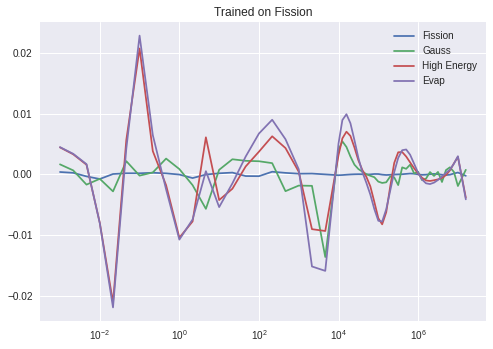

In [23]:
x,y = fission(N)
plot_resids(x,y)
plt.title("Trained on Fission")

Fission : 7.398094e-04
Gauss : 4.794799e-04
High Energy : 9.810461e-04
Evap : 1.129354e-03


Text(0.5, 1.0, 'Trained on Gaussian')

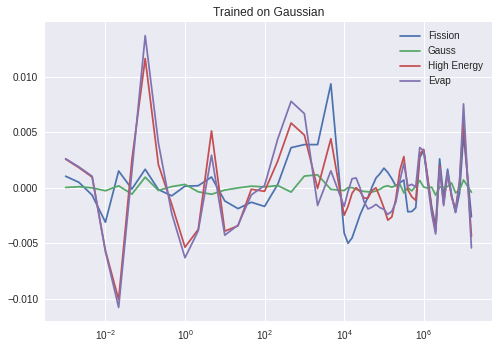

In [24]:
x,y = gauss(N)
plot_resids(x,y)
plt.title("Trained on Gaussian")

Fission : 5.047611e-05
Gauss : 8.732800e-05
High Energy : 2.684163e-05
Evap : 2.957700e-05


Text(0.5, 1.0, 'Trained on High Energy')

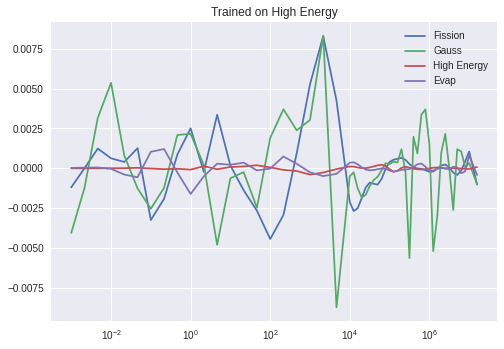

In [25]:
x,y = highenergy(N)
plot_resids(x,y)
plt.title("Trained on High Energy")

Fission : 9.769380e-05
Gauss : 1.729840e-04
High Energy : 3.836566e-05
Evap : 3.361510e-05


Text(0.5, 1.0, 'Trained on Evaporation')

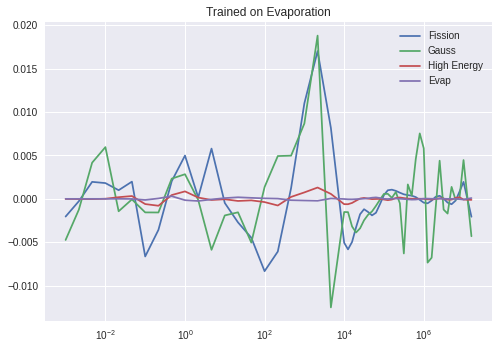

In [26]:
x,y = evap(N)
plot_resids(x,y)
plt.title("Trained on Evaporation")

# ML for Residual Guessing

In [31]:
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Flatten, Reshape, LeakyReLU, Dense, Activation, Dropout, InputLayer, Input
from tensorflow.keras.layers import LeakyReLU
import tensorflow.keras.initializers
import statistics
import tensorflow.keras as keras

import constants
import data_generation

def generate_model(layer1, layer2, layer3, drop):
    
    model = Sequential()
    
    model.add(Dense(int(layer1), activation = "sigmoid"))
    model.add(Dropout(drop))
    model.add(Dense(int(layer2), activation = "sigmoid"))
    model.add(Dropout(drop))
    model.add(Dense(int(layer3), activation = "sigmoid"))
    model.add(Dropout(drop))
    model.add(Dense(int(data_generation.yDim), activation = "relu"))
    
    return model

In [38]:
model = generate_model(300, 300, 300, 0.1)
model.compile(loss = "mse", optimizer = Adam(learning_rate=0.001))

x,y = fission(1000)
resid = (y - np.matmul(x, wFission))**2

SPLITS = 1
boot = ShuffleSplit(n_splits = SPLITS, test_size = 0.2)

In [39]:
for train, test in boot.split(resid):
    xtrain, ytrain = x[train], y[train]
    xtest, ytest = x[test], y[test]
    
    model.fit(xtrain, ytrain, validation_data = (xtest, ytest), epochs=10, batch_size = 64, verbose = 0)

In [40]:
x,y = fission(100)
resid = (y - np.matmul(x, wFission))**2

yGuess = model(x)

Text(0.5, 1.0, 'Showing that Neural Network determines the best Residual-Guessing Strategy is to not guess at all')

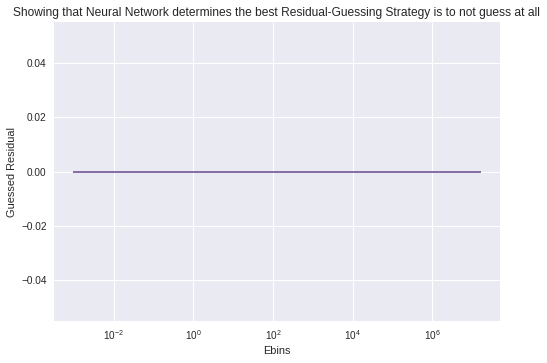

In [41]:
for guess in yGuess:
    plt.plot(Ebins, guess)

plt.xscale("log")
plt.xlabel("Ebins")
plt.ylabel("Guessed Residual")
plt.title("Showing that Neural Network determines the best Residual-Guessing Strategy is to not guess at all")

# Showing that Well-Engineered Training Data Returns the Correct Pseudo-Inverse

In [42]:
def eval_w(w):
    x,y = loadXY()
    return np.mean((y - np.matmul(x, w))**2)

def is_w_pseudoinv(w):
    return np.mean( ( np.matmul(cm, w.T) - np.identity(15) )**2 )

In [10]:
N = 1000
x,y = fission(N)
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)
print("Unfolding ? :", eval_w(w))
print("Identity ? :", is_w_identity(w))

Unfolding ? : 0.0001551915600711581
Identity ? : 4.0856441505099135e-16


In [46]:
x,y = fission(N)
x,y = [x[0]], [y[0]]
for j in range(N):
    ynew = y[0] * ( np.random.random(len(y[0])) )
    ynew = ynew / np.sum(ynew)
    
    y.append( ynew )
    x.append( np.matmul(cm, ynew) )
x = np.array(x)
y = np.array(y)

w = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

w = np.matmul(np.linalg.pinv(x), y)
print("Unfolding ? :", eval_w(w))
print("Identity ? :", is_w_identity(w))

Unfolding ? : 19.873022590292006
Identity ? : 2.4488907042561085e-27


In [42]:
x,y = [],[]
for _ in range(N):
    yrand = np.random.random(53)
    yrand = yrand / np.sum(yrand)
    y.append(yrand)
    x.append(np.matmul(cm,yrand))
x = np.array(x)
y = np.array(y)

w = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

print("Unfolding ? :", eval_w(w))
print("Identity ? :", is_w_identity(w))

Unfolding ? : 0.0002383532104378061
Identity ? : 2.4079160239078443e-14


# Point on Training Related to the Specificity of the Training Set

In [50]:
N = 5000

In [51]:
x,y = loadXY()
perturb0 = 0
y_perturb = y[perturb0]
x_perturb = x[perturb0]

x,y = [],[]

for _ in range(N):
    
    ynew = y_perturb + 0.1 * ( 0.5 - np.random.random(len(y_perturb)) )
    ynew = ynew / np.sum(ynew)
    y.append(ynew)
    
    xnew = np.matmul( cm, ynew )
    x.append(xnew)

x,y = np.array(x),np.array(y)
    
w0 = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

In [52]:
x,y = loadXY()
perturb1 = 50
y_perturb = y[perturb1]
x_perturb = x[perturb1]

x,y = [],[]

for _ in range(N):
    
    ynew = y_perturb + 0.1 * ( 0.5 - np.random.random(len(y_perturb)) )
    ynew = ynew / np.sum(ynew)
    y.append(ynew)
    
    xnew = np.matmul( cm, ynew )
    x.append(xnew)

x,y = np.array(x),np.array(y)
    
w1 = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

Text(0.5, 1.0, 'Linear Regression,\nFor an Evaporation Spectra')

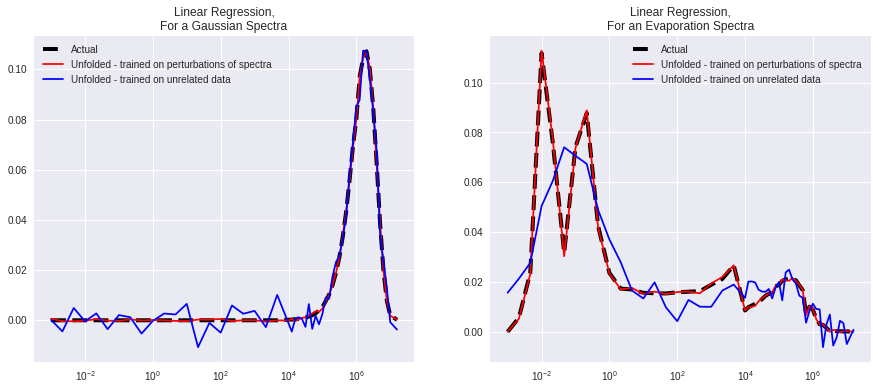

In [53]:
x,y = loadXY()

fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].plot(Ebins, y[perturb0], label = "Actual", color = "black", linestyle = "dashed", linewidth = 4)
axs[0].plot(Ebins, np.matmul(x[perturb0], w0), label = "Unfolded - trained on perturbations of spectra", color = "red")
axs[0].plot(Ebins, np.matmul(x[perturb0], w1), label = "Unfolded - trained on unrelated data", color = "blue")

axs[1].plot(Ebins, y[perturb1], label = "Actual", color = "black", linestyle = "dashed", linewidth = 4)
axs[1].plot(Ebins, np.matmul(x[perturb1], w1), label = "Unfolded - trained on perturbations of spectra", color = "red")
axs[1].plot(Ebins, np.matmul(x[perturb1], w0), label = "Unfolded - trained on unrelated data", color = "blue")

axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Linear Regression,\nFor a Gaussian Spectra")
axs[1].set_title("Linear Regression,\nFor an Evaporation Spectra")

# Shuffle data, determine if the average of multiple distinct inversion matrices gives better performance:

### ( Mean vs Bias Tradeoff )

In [54]:

def evaluate_mean_bias():
    x,y = loadXY()

    use, reserve = next(ShuffleSplit(n_splits = 1, test_size = 0.1).split(x))

    xdata, ydata = x[use], y[use]
    xreserve, yreserve = x[reserve], y[reserve]

    models = []

    splits = 1000
    boot = ShuffleSplit(n_splits = splits, test_size = 0.4)
    for train, ignore in boot.split(xdata):
        xtrain, ytrain = xdata[train], ydata[train]

        models.append(np.matmul(np.matmul(np.linalg.inv(np.matmul(xtrain.T, xtrain)), xtrain.T), ytrain))

    models = np.array(models)

    ypred = np.zeros(yreserve.shape)
    modelMSEs = []
    for model in models:
        ypred += np.matmul(xreserve, model)
        modelMSEs.append( np.mean( ( yreserve - np.matmul(xreserve, model) )**2 ) ) 
    ypred = ypred / len(models)
    totalMSE = np.mean( ( ypred - yreserve )**2 )
    
    return modelMSEs, totalMSE


In [49]:
min_MSE_subset = []
std_MSE_subset = []
avg_MSE_subset = []

avg_MSE_all_subsets = []

for _ in range(1000):
    modelMSEs, totalMSE = evaluate_mean_bias()
    
    min_MSE_subset.append(np.min(modelMSEs))
    std_MSE_subset.append(np.std(modelMSEs))
    avg_MSE_subset.append(np.mean(modelMSEs))
    avg_MSE_all_subsets.append(totalMSE)

KeyboardInterrupt: 

In [ ]:

x,y = loadXY()
pseudoinv = np.linalg.pinv(cm.T)
baseline = np.mean( ( y - np.matmul(x, pseudoinv) )**2 )


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

axs[0][0].hist(min_MSE_subset, bins=50, color = "blue", label = "Minimum Unfolding MSE across all Data Folds")
axs[0][0].set_xlim(0, 0.0003)
axs[0][0].vlines(baseline, 0, 50, color = "black", label = "Moore-Penrose Pseudo-Inverse Unfolding MSE")
axs[0][0].legend()

axs[0][1].hist(std_MSE_subset, bins=50, color = "blue", label = "Deviation in MSE across all Data Folds")
axs[0][1].set_xlim(0, 0.00015)
axs[0][1].legend()

axs[1][0].hist(avg_MSE_subset, bins=50, color = "blue", label = "Average MSE across all Data Folds")
axs[1][0].set_xlim(0, 0.0003)
axs[1][0].vlines(baseline, 0, 50, color = "black", label = "Moore-Penrose Pseudo-Inverse Unfolding MSE")
axs[1][0].legend()

axs[1][1].hist(avg_MSE_all_subsets, bins=50, color = "blue", label = "MSE of Averaged Unfolding across all Data Folds")
axs[1][1].set_xlim(0, 0.0003)
axs[1][1].vlines(baseline, 0, 50, color = "black", label = "Moore-Penrose Pseudo-Inverse Unfolding MSE")
axs[1][1].legend()

None